In [1]:
import math
import os
import pickle
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import torch

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation/blob/master/Load%20Data.ipynb

remove_keys = [
  # FOLLOWS THE ORIGINAL REPO
  # remove batteries that do not reach 80% capacity
  'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22',      
  # remove batteries from batch 2 that are moved to batch 1
  'b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16',      
  # remove noisy channels from batch3
  'b3c37', 'b3c2', 'b3c23', 'b3c32', 'b3c42', 'b3c43',
  
  # NEWLY DELETED HERE
  # remove outlier with abnormal capacity
  'b1c0', 'b1c18', 'b2c12', 'b2c44'
]
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

temperature_feature_interval = 1
current_feature_interval = 1

cap_outlier_diff_threshold = 0.015

curve_ratio_min = 0.5
curve_ratio_max = 0.99
curve_ratio_steps = 9
curve_ratio_digits = 2
curve_ratio_step_size = (curve_ratio_max - curve_ratio_min) / curve_ratio_steps

In [3]:
data_dir_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/Stanford University battery dataset'
batch1 = pickle.load(open(os.path.join(data_dir_path,'batch1.pkl'), 'rb'))
batch2 = pickle.load(open(os.path.join(data_dir_path,'batch2.pkl'), 'rb'))
batch3 = pickle.load(open(os.path.join(data_dir_path,'batch3.pkl'), 'rb'))

for i, bk in enumerate(batch1_keys):
  batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
  for j in batch1[bk]['summary'].keys():
    if j == 'cycle':
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
    else:
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
  last_cycle = len(batch1[bk]['cycles'].keys())
  for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
    batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
    
batch = {**batch1, **batch2, **batch3}
for key in remove_keys:
  del batch[key]

In [4]:
max_temps = []
min_temps = []
for key in batch.keys():
  max_temps.append(np.max(batch[key]['summary']['Tmax']))
  min_temps.append(np.min(batch[key]['summary']['Tmin'][np.nonzero(batch[key]['summary']['Tmin'])]))
max_temp = np.max(max_temps)
min_temp = np.min(min_temps)

max_currents = []
min_currents = []
for key in batch.keys():
  for cycle in batch[key]['cycles'].keys():
    max_currents.append(np.max(batch[key]['cycles'][cycle]['I']))
    min_currents.append(np.min(batch[key]['cycles'][cycle]['I']))
max_current = np.max(max_currents)
min_current = np.min(min_currents)

In [5]:
data_path = '/Users/keilongwong/Library/CloudStorage/OneDrive-個人/IPM PhD/Thesis/Data/data from internet/LG 18650HG2 Li-ion Battery Data/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020'

temp_to_test = ['40degC', '25degC', '10degC']

# loop all csv in data_path and append all rows in one dataframe
df = pd.DataFrame()
for dir in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, dir)):
        continue
    if dir not in temp_to_test:
        continue
    for file in os.listdir(os.path.join(data_path, dir)):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(data_path, dir, file)
        # print(file_path)
        time_stamp_line_idx = 0

        with open(file_path) as f:
            for i, line in enumerate(f):
                if 'Time Stamp' in line:
                    time_stamp_line_idx = i
                    break
        
        new_df = pd.read_csv(file_path, 
                                skiprows=time_stamp_line_idx + 2, 
                                header=None,
                                index_col=False,
                                names=['Time Stamp',
                                    'Step',
                                    'Status',
                                    'Prog Time',
                                    'Step Time',
                                    'Cycle',
                                    'Cycle Level',
                                    'Procedure',
                                    'Voltage',
                                    'Current',
                                    'Temperature',
                                    'Capacity',
                                    'WhAccu',
                                    'Cnt'],
                                )
        new_df = new_df.drop_duplicates()
        
        # remove date only rows
        new_df = new_df[new_df['Time Stamp'].str.len() > 10]
        
        # print(file_path)
        new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp'], format='%m/%d/%Y %I:%M:%S %p').apply(lambda x: x.timestamp())
        
        # new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp']).apply(lambda x: x.timestamp())
        
        new_df['Exp Temperature'] = dir
        new_df['Cycle Name'] = file[:-4]
        new_df['Exp Name'] = dir + '__' + file[:-4]
        
        new_df['Index'] = new_df.index
        
        df = pd.concat([df, new_df])
                

df = df[df['Status'].isin([
                           'DCH', 
                           'PAU', 
                           'CHA', 
                        #    'STO',
                           'TABLE', 
                        #    'MSG'
                           ])]
                
df.sort_values(by=['Timestamp', 'Index'], inplace=True)

df['Status Consecutive'] = (df['Status'] != df['Status'].shift()).cumsum()
df['Status Unique'] = df['Status'] + df['Status Consecutive'].astype(str)

cycle_count = 0
for key, group in df.groupby('Exp Name', sort=False):
  df.loc[group.index, 'Cycle Num'] = cycle_count
  cycle_count += 1      
  
df.reset_index(drop=True, inplace=True)
df['Index'] = df.index


In [6]:
for key, group in df.groupby(['Exp Name', 'Status Unique'], sort=False):
  print(key)

('25degC__549_Charge', 'PAU1')
('25degC__549_Charge', 'CHA2')
('25degC__549_Charge', 'PAU3')
('25degC__549_HPPC', 'PAU3')
('25degC__549_HPPC', 'DCH4')
('25degC__549_HPPC', 'PAU5')
('25degC__549_HPPC', 'CHA6')
('25degC__549_HPPC', 'PAU7')
('25degC__549_HPPC', 'DCH8')
('25degC__549_HPPC', 'PAU9')
('25degC__549_HPPC', 'CHA10')
('25degC__549_HPPC', 'PAU11')
('25degC__549_HPPC', 'DCH12')
('25degC__549_HPPC', 'PAU13')
('25degC__549_HPPC', 'CHA14')
('25degC__549_HPPC', 'PAU15')
('25degC__549_HPPC', 'DCH16')
('25degC__549_HPPC', 'PAU17')
('25degC__549_HPPC', 'CHA18')
('25degC__549_HPPC', 'PAU19')
('25degC__549_HPPC', 'DCH20')
('25degC__549_HPPC', 'PAU21')
('25degC__549_HPPC', 'DCH22')
('25degC__549_HPPC', 'PAU23')
('25degC__549_HPPC', 'CHA24')
('25degC__549_HPPC', 'PAU25')
('25degC__549_HPPC', 'DCH26')
('25degC__549_HPPC', 'PAU27')
('25degC__549_HPPC', 'CHA28')
('25degC__549_HPPC', 'PAU29')
('25degC__549_HPPC', 'DCH30')
('25degC__549_HPPC', 'PAU31')
('25degC__549_HPPC', 'CHA32')
('25degC__549_

In [7]:
df.to_csv('all_data.csv', index=False)

In [8]:
df

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,WhAccu,Cnt,Timestamp,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num
0,10/25/2018 4:09:59 AM,4,PAU,00:01:00.013,00:01:00.002,0,0,NN_Char_Charge,3.10125,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC__549_Charge,0,1,PAU1,102.0
1,10/25/2018 4:10:59 AM,4,PAU,00:02:00.013,00:02:00.002,0,0,NN_Char_Charge,3.10192,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC__549_Charge,1,1,PAU1,102.0
2,10/25/2018 4:11:59 AM,4,PAU,00:03:00.015,00:03:00.004,0,0,NN_Char_Charge,3.10260,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC__549_Charge,2,1,PAU1,102.0
3,10/25/2018 4:12:59 AM,4,PAU,00:04:00.014,00:04:00.003,0,0,NN_Char_Charge,3.10344,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC__549_Charge,3,1,PAU1,102.0
4,10/25/2018 4:13:59 AM,4,PAU,00:05:00.013,00:05:00.002,0,0,NN_Char_Charge,3.10412,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC__549_Charge,4,1,PAU1,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662574,11/26/2018 12:40:49 PM,43,PAU,10:27:01.775,00:09:59.603,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC__582_LA92,2662574,843,PAU843,102.0
2662575,11/26/2018 12:40:49 PM,43,PAU,10:27:01.874,00:09:59.702,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC__582_LA92,2662575,843,PAU843,102.0
2662576,11/26/2018 12:40:49 PM,43,PAU,10:27:01.975,00:09:59.803,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC__582_LA92,2662576,843,PAU843,102.0
2662577,11/26/2018 12:40:49 PM,43,PAU,10:27:02.076,00:09:59.904,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC__582_LA92,2662577,843,PAU843,102.0


In [9]:
cycle_configs = cycle_configs = [
  # [('25degC__551_Cap_1C', 'ALL'), ('25degC__551_Charge2', 'CHA238')],
  # [('25degC__551_UDDS', 'ALL'), ('25degC__551_Charge3', 'CHA242')],
  # short charge time
  # [('25degC__551_HWFET', 'ALL'), ('25degC__551_Charge4', 'CHA246')],
  [('25degC__551_LA92', 'ALL'), ('25degC__551_Charge5', 'CHA250')],
  [('25degC__551_US06', 'ALL'), ('25degC__551_Charge6', 'CHA254')],
  [('25degC__551_Mixed1', 'ALL'), ('25degC__551_Charge7', 'CHA258')],
  [('25degC__551_Mixed2', 'ALL'), ('25degC__551_Charge8', 'CHA262')],
  # [('25degC__552_Cap_1C', 'ALL'), ('25degC__552_Charge9', 'CHA266')],
  [('25degC__552_Mixed3', 'ALL'), ('25degC__552_Charge10', 'CHA270')],
  [('25degC__552_Mixed4', 'ALL'), ('25degC__552_Charge11', 'CHA274')],
  [('25degC__552_Mixed5', 'ALL'), ('25degC__552_Charge12', 'CHA278')],
  [('25degC__552_Mixed6', 'ALL'), ('25degC__552_Charge13', 'CHA282')],
  [('25degC__552_Mixed7', 'ALL'), ('25degC__552_Charge14', 'CHA286')],
  [('25degC__552_Mixed8', 'ALL'), ('25degC__552_Charge15', 'CHA290')],
  
  # abnormal high capacity
  # [('40degC__555_C20DisCh', 'ALL'), ('40degC__555_C20DisCh', 'CHA506')],
  # [('40degC__555_Dis_0p5C', 'ALL'), ('40degC__555_Dis_0p5C', 'CHA510')],
  # [('40degC__555_Dis_2C', 'ALL'), ('40degC__555_Dis_2C', 'CHA514')],
  [('40degC__556_UDDS', 'ALL'), ('40degC__556_Charge3', 'CHA522')],
  [('40degC__556_HWFET', 'ALL'), ('40degC__556_Charge4', 'CHA526')],
  [('40degC__556_LA92', 'ALL'), ('40degC__556_Charge5', 'CHA530')],
  [('40degC__556_US06', 'ALL'), ('40degC__556_Charge6', 'CHA534')],
  [('40degC__556_Mixed1', 'ALL'), ('40degC__556_Charge7', 'CHA538')],
  [('40degC__556_Mixed2', 'ALL'), ('40degC__556_Charge8', 'CHA542')],
  # [('40degC__557_Cap_1C', 'ALL'), ('40degC__557_Charge9', 'CHA546')],
  # [('40degC__557_Mixed3', 'ALL'), ('40degC__562_Charge10', 'CHA550')],
  # short charge time
  # [('40degC__562_Mixed4', 'ALL'), ('40degC__562_Charge11', 'CHA554')],
  # [('40degC__562_Mixed5', 'ALL'), ('40degC__562_Charge12', 'CHA558')],
  # [('40degC__562_Mixed6', 'ALL'), ('40degC__562_Charge13', 'CHA562')],
  # [('40degC__562_Mixed7', 'ALL'), ('40degC__562_Charge14', 'CHA566')],
  # [('40degC__562_Mixed8', 'ALL'), ('40degC__562_Charge15', 'CHA570')],
  [('10degC__567_US06', 'ALL'), ('10degC__567_Charge6', 'CHA578')],
  [('10degC__567_Mixed1', 'ALL'), ('10degC__567_Charge7', 'CHA582')],
  [('10degC__567_Mixed2', 'ALL'), ('10degC__567_Charge8', 'CHA586')],
  # [('10degC__571_Cap_1C', 'ALL'), ('10degC__571_Charge10', 'CHA590')],
  [('10degC__571_Mixed4', 'ALL'), ('10degC__571_Charge11', 'CHA594')],
  [('10degC__571_Mixed5', 'ALL'), ('10degC__571_Charge12', 'CHA598')],
  [('10degC__571_Mixed6', 'ALL'), ('10degC__571_Charge13', 'CHA602')],
  [('10degC__571_Mixed7', 'ALL'), ('10degC__571_Charge14', 'CHA606')],
  [('10degC__571_Mixed8', 'ALL'), ('10degC__571_Charge15', 'CHA610')],
  
  # abnormal high capacity
  # [('10degC__575_C20DisCh', 'ALL'), ('10degC__575_C20DisCh', 'CHA818')],
  # [('10degC__575_Dis_0p5C', 'ALL'), ('10degC__575_Dis_0p5C', 'CHA822')],
  # [('10degC__575_Dis_2C', 'ALL'), ('10degC__575_Dis_2C', 'CHA826')],
  # [('10degC__576_Cap_1C', 'ALL'), ('10degC__576_Charge2', 'CHA832')],
  # [('10degC__576_UDDS', 'ALL'), ('10degC__576_Charge3', 'CHA836')],
  # [('10degC__576_HWFET', 'ALL'), ('10degC__576_Charge4', 'CHA840')]
]

In [10]:
cycle_data = {}

for i, cycle_config in enumerate(cycle_configs):
  if len(cycle_config) == 3:
    cycle_names = [cycle_config[0], cycle_config[1]]
    charge_cycle_name = cycle_config[2]
  else:
    cycle_names = [cycle_config[0]]
    charge_cycle_name = cycle_config[1]
  
  if len(cycle_names) == 1 and cycle_names[0][1] == 'ALL' and cycle_names[0][0] != charge_cycle_name[0]:
    cycle_names.append((charge_cycle_name[0], 'ALL'))
  
  print(cycle_names)
  
  cycle_df = pd.DataFrame()
  for cycle_name in cycle_names:
    if cycle_name[1] == 'ALL':
      selected_df = df[df['Exp Name'] == cycle_name[0]]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    elif type(cycle_name[1]) == str:
      selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == cycle_name[1])]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {cycle_name[1]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    else:
      for status_name in cycle_name[1]:
        selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == status_name)]
        if len(selected_df) <= 0:
          print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {status_name}')
      cycle_df = pd.concat([cycle_df, selected_df])
  
  cap = 0
  charge_df = df[(df['Exp Name'] == charge_cycle_name[0]) & (df['Status Unique'] == charge_cycle_name[1]) & (df['Voltage'].astype(float) < 4.2)]
  if len(charge_df) <= 0:
    print(f'Cannot find charge cycle with exp name: {charge_cycle_name[0]} and status: {charge_cycle_name[1]}')
  cap = np.trapz(charge_df['Current'], charge_df['Timestamp']) / 3600
  # print(len(charge_df))
  # cap = charge_df['Capacity'].max()
  cap = cap / 3.0
  
  def _convert_time_to_date(x):
    x_split = x.split(':')
    hour = int(x_split[0])
    day = hour // 24 + 1
    hour = hour % 24
    return f"1900/01/{day:02d} {hour}:{x_split[1]}:{x_split[2]}"
    
  # for key, group in cycle_df.groupby('Status Unique', sort=False):
  #   group_prog_time = group['Prog Time'].apply(_convert_time_to_date)
  #   group_prog_time.sort_index(inplace=True)
  #   cycle_df.loc[group.index, 'Prog Time Delta'] = pd.to_datetime(group_prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp()).diff().fillna(0)
  
  prog_time = cycle_df['Prog Time'].apply(_convert_time_to_date)
  cycle_df['Prog Timestamp'] = pd.to_datetime(prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp())
  cycle_df['Prog Time Delta'] = cycle_df['Prog Timestamp'].diff().fillna(0)
  
  # if(cycle_df['Prog Time Delta'].min() < 0):
  #   print(cycle_config)
  #   print(cycle_df['Prog Time Delta'].min())
  
  cycle_df.loc[cycle_df['Prog Time Delta'] < 0, 'Prog Time Delta'] = 0
    
  # cycle_df['Step Timestamp'] = pd.to_datetime(cycle_df['Step Time'], format='%H:%M:%S.%f').apply(lambda x: x.timestamp())
  # cycle_df['t'] = cycle_df['Step Timestamp'] - cycle_df['Step Timestamp'].min()
    
  cycle_df.sort_values(by=['Timestamp', 'Index'], inplace=True)
  cycle_df['t'] = cycle_df['Prog Time Delta'].cumsum()
  cycle_df['t'] = cycle_df['t'] - cycle_df['t'].min()
  cycle_df.sort_values(by=['t', 'Index'], inplace=True)
  
  cycle_data[i] = {
    'cycle': cycle_df,
    'cap': cap
  }

[('25degC__551_LA92', 'ALL'), ('25degC__551_Charge5', 'ALL')]
[('25degC__551_US06', 'ALL'), ('25degC__551_Charge6', 'ALL')]
[('25degC__551_Mixed1', 'ALL'), ('25degC__551_Charge7', 'ALL')]
[('25degC__551_Mixed2', 'ALL'), ('25degC__551_Charge8', 'ALL')]
[('25degC__552_Mixed3', 'ALL'), ('25degC__552_Charge10', 'ALL')]
[('25degC__552_Mixed4', 'ALL'), ('25degC__552_Charge11', 'ALL')]
[('25degC__552_Mixed5', 'ALL'), ('25degC__552_Charge12', 'ALL')]
[('25degC__552_Mixed6', 'ALL'), ('25degC__552_Charge13', 'ALL')]
[('25degC__552_Mixed7', 'ALL'), ('25degC__552_Charge14', 'ALL')]
[('25degC__552_Mixed8', 'ALL'), ('25degC__552_Charge15', 'ALL')]
[('40degC__556_UDDS', 'ALL'), ('40degC__556_Charge3', 'ALL')]
[('40degC__556_HWFET', 'ALL'), ('40degC__556_Charge4', 'ALL')]
[('40degC__556_LA92', 'ALL'), ('40degC__556_Charge5', 'ALL')]
[('40degC__556_US06', 'ALL'), ('40degC__556_Charge6', 'ALL')]
[('40degC__556_Mixed1', 'ALL'), ('40degC__556_Charge7', 'ALL')]
[('40degC__556_Mixed2', 'ALL'), ('40degC__556

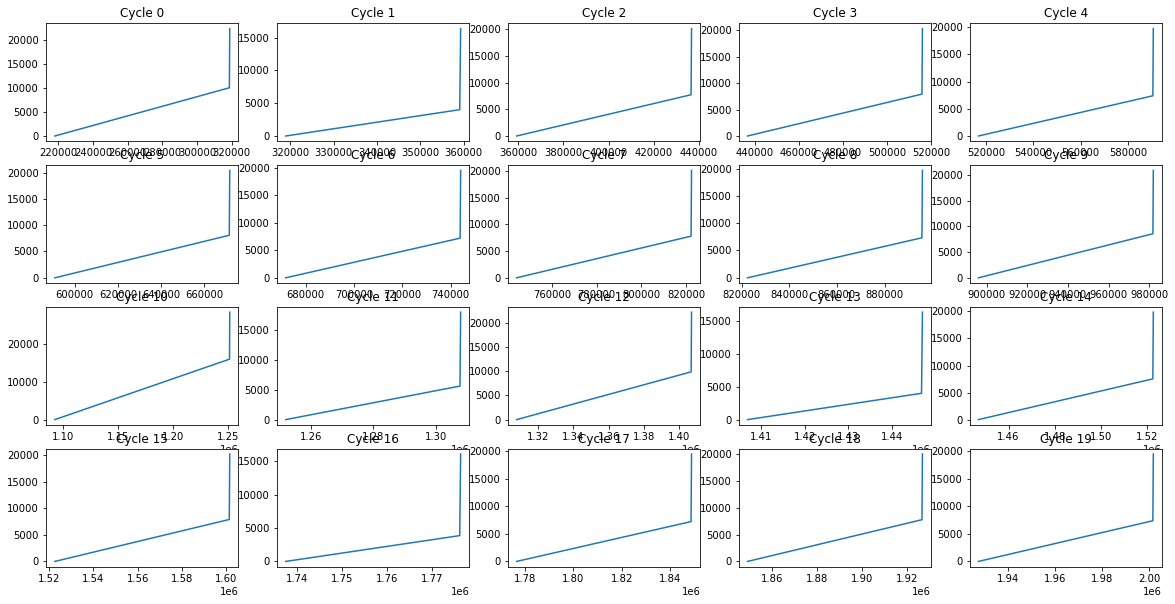

In [11]:
# plot all cycle_data cycle 't' into sub plots
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
  if i >= len(cycle_data):
    break
  cycle_data[i]['cycle']['t'].plot(ax=ax)
  ax.set_title(f'Cycle {i}')

In [12]:
caps = []
feats = []

for i in range(len(cycle_data)):
  caps.append(cycle_data[i]['cap'])
  
  cycle = cycle_data[i]['cycle']
  time = cycle['t'].values / 60 # to minutes (align with MIT Stanford dataset)
  current = cycle['Current'].values
  temp = cycle['Temperature'].values
  feat = [
    np.trapz((current == 0).astype(np.float32), time),
    np.trapz((current > 0).astype(np.float32), time),
    np.trapz((current < 0).astype(np.float32), time),
    max(current),
    abs(min(current))
  ]
      
  for t in range(math.floor(min_temp), math.ceil(max_temp), temperature_feature_interval):
    feat = np.append(feat, np.trapz(((temp > t) & (temp <= t+temperature_feature_interval)).astype(np.float32), time))
  # only check charging current (I>0), as the discharge cycles are constant
  for c in range(0, math.ceil(max_current), current_feature_interval):
    feat = np.append(feat, np.trapz(((current > c) & (current <= c+current_feature_interval)).astype(np.float32), time))
  feats.append(feat)

In [13]:
for i in range(len(cycle_data)):
  print(cycle_data[i]['cycle'].iloc[0]['Exp Name'], cycle_data[i]['cap'])

25degC__551_LA92 0.8529968120370373
25degC__551_US06 0.8529453097222222
25degC__551_Mixed1 0.8551238162037036
25degC__551_Mixed2 0.8546467583333333
25degC__552_Mixed3 0.8455370648148147
25degC__552_Mixed4 0.8439574305555554
25degC__552_Mixed5 0.8436947597222222
25degC__552_Mixed6 0.844283759259259
25degC__552_Mixed7 0.8440167666666665
25degC__552_Mixed8 0.8458399296296295
40degC__556_UDDS 0.8392558421296296
40degC__556_HWFET 0.8307286449074076
40degC__556_LA92 0.8348091499999999
40degC__556_US06 0.8312976949074077
40degC__556_Mixed1 0.8341659273148146
40degC__556_Mixed2 0.8332277861111108
10degC__567_US06 0.817578888888889
10degC__567_Mixed1 0.8158085972222224
10degC__567_Mixed2 0.8164104129629629
10degC__571_Mixed4 0.7771880291666666
10degC__571_Mixed5 0.7771388097222222
10degC__571_Mixed6 0.7807528685185186
10degC__571_Mixed7 0.7783787013888888
10degC__571_Mixed8 0.7781905300925924


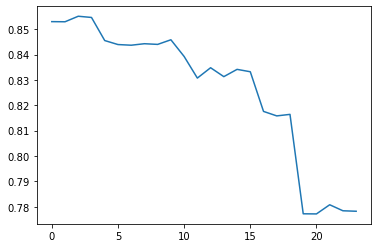

In [14]:
plt.plot(caps)

In [15]:
pre_processed_data = {
  'driving_cycle': {
    'capacities': torch.tensor(np.array(caps), dtype=torch.float32),
    'features': torch.tensor(np.array(feats), dtype=torch.float32)
  }
}

os.makedirs('./LG 18650HG2 Li-ion Battery Data', exist_ok=True)
pickle.dump(pre_processed_data, open('./LG 18650HG2 Li-ion Battery Data/preprocessed_data.pkl', 'wb'))